### А/Б тестирование предзаполнения на чекауте

В данном анализе проводится исследование результатов A/B теста, целью которого было оценить влияние изменения интерфейса на вкладке “Give once” на поведение пользователей при совершении пожертвований. В контрольной группе поле было предзаполнено значением 100$, а в тестовой группе предзаполнение убрано.
Определим ключевые метрики для анализа, проведем анализ и сформируем рекомендации на основе полученных данных.

### Оглавление

1. **Предварительный анализ данных**
   - Импорт библиотек и загрузка файла
   - Сводная таблица
   - Проверка и преобразование данных
   - Результирующая таблица с уникальными пользователями

2. **Метрики**
   - Основные метрики тест/контроль
   - Распределение сумм и выбросы
   - Сравнение метрик тест/контроль (без выбросов)
   - Регулярные платежи

3. **Гипотезы и статистический анализ**
   - Гипотеза 1
   - Вывод 1
   - Гипотеза 2
   - Вывод 2

4. **Результаты анализа и рекомендации**


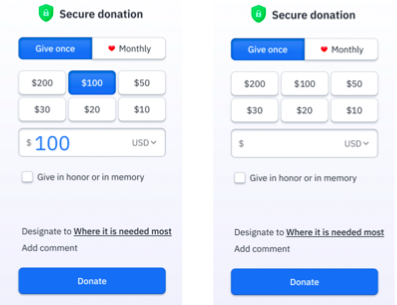

# 2. Предварительный анализ данных

### Импорт библиотек и загрузка файла

В файле FRU_analytics_task1.csv находятся исходные логи АБ-теста:
- ClientID - ID пользователя
- EventTime - время события
- EventType - тип события (checkoutView - открытие чекаута, charge - создание доната)
- DonationType - тип доната (one-time - разовый доната, recurring - регулярный донат с - частотой списания раз в месяц).
- AmountInUSD - размер доната в $.
- tag - группа, в которую попал пользователь (control/test)

In [34]:
import pandas as pd
import plotly.express as px
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, norm


pd.set_option('display.max_columns', 100)

In [35]:
# If a FileNotFoundError occurs, upload the CSV to the files section (left top bar, last icon).
df = pd.read_csv('FRU_analytics_test_task.csv')
df_init = df.copy()
df.head()

,ClientID,EventTime,EventType,DonationType,AmountInUSD,tag
0,885410877,2022-07-20 00:00:23,checkoutView,NaN,NaN,control
1,859319263,2022-07-20 00:00:48,checkoutView,NaN,NaN,test
2,480984859,2022-07-20 00:00:58,checkoutView,NaN,NaN,control
3,204664871,2022-07-20 00:01:00,checkoutView,NaN,NaN,test
4,859319263,2022-07-20 00:01:05,checkoutView,NaN,NaN,test


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58770 entries, 0 to 58769
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ClientID      58770 non-null  int64  
 1   EventTime     58770 non-null  object 
 2   EventType     58770 non-null  object 
 3   DonationType  5364 non-null   object 
 4   AmountInUSD   5364 non-null   float64
 5   tag           53406 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 2.7+ MB


### Сводная таблица
Построим сводную таблицу, чтобы лучше понять структуру данных. Также посмотрим на группы в динамике по дням, для этого добавим новое поле с датой без времени.

In [37]:
grouped_df = df.groupby(['EventType','DonationType','tag'],dropna=False).agg({
    'ClientID': ['count', 'nunique'],
    'AmountInUSD': ['sum', 'count', 'min', 'max', 'mean']
})
grouped_df

ClientID         AmountInUSD              \
                                     count nunique         sum count   min   
EventType    DonationType tag                                                
charge       one-time     NaN         5189    4939    412301.0  5189   5.0   
             recurring    NaN          175     175      7893.0   175  10.0   
checkoutView NaN          control    26642   21152         0.0     0   NaN   
                          test       26764   21109         0.0     0   NaN   

                                                       
                                       max       mean  
EventType    DonationType tag                          
charge       one-time     NaN      10000.0  79.456735  
             recurring    NaN        127.0  45.102857  
checkoutView NaN          control      NaN        NaN  
                          test         NaN        NaN

In [38]:
df['Day'] = pd.to_datetime(df['EventTime']).dt.date
grouped = df.groupby(['Day', 'tag'])['ClientID'].nunique().reset_index()

fig = px.bar(grouped, x='Day', y='ClientID', color='tag',
             title='Number of unique clients daily',
             labels={'ClientID': 'Unique clients', 'Day': 'Day'},
             text='ClientID',
             barmode='stack')

fig.update_layout(xaxis_title="Day", yaxis_title="Unique clients")

fig.show()

### Проверка и преобразование данных
В этом пункте хотелось бы проверить несколько важных для анализа вопросов и сделать необходимые преобразования.

Вопросы:
- Сколько событий может быть по клиенту?
- Клиент совершает действия в разные дни?
- Сплитование по клиенту или событию?
- Юзер делает один вид доната?

Преобразования:
- Оставим только первую запись по каждому клиенту
- Заполним пустые поля (тип доната, количество ивентов)
- Добавим новые поля (сумма и количество донатов, размер наибольшего и наименьшего доната, флаг доната, флаг регулярного доната)

In [39]:
df2= df.copy()
df2['count_events'] = df2.groupby('ClientID')['ClientID'].transform('count')
df2_count = df2.groupby('count_events').agg({
    'ClientID': 'count'
})
df2_count

,ClientID
count_events,
1,28007
2,24718
3,4794
4,936
5,315


In [40]:
df2.sort_values(by=['count_events', 'ClientID', 'EventTime'], ascending=[False, True, True], inplace=True)
df2.head(6)


,ClientID,EventTime,EventType,DonationType,AmountInUSD,tag,Day,count_events
37854,128104739,2022-07-24 12:32:24,checkoutView,NaN,NaN,control,2022-07-24,5
37857,128104739,2022-07-24 12:33:20,checkoutView,NaN,NaN,control,2022-07-24,5
37875,128104739,2022-07-24 12:36:15,charge,one-time,20.0,NaN,2022-07-24,5
37878,128104739,2022-07-24 12:36:29,checkoutView,NaN,NaN,control,2022-07-24,5
37898,128104739,2022-07-24 12:38:49,charge,one-time,5.0,NaN,2022-07-24,5
58250,137693194,2022-07-26 22:24:29,checkoutView,NaN,NaN,control,2022-07-26,5


Тут проверили, что сплитование происходит по клиентам

In [41]:
df_split = df.groupby('ClientID').agg({
    'tag': 'nunique'
}).sort_values(by='tag', ascending=False)
df_split.head(2)

,tag
ClientID,
100015892,1
700484767,1


Тут проверим юзеров с активностями в разные дни. Их немного, проверим вручную. Оказалось, что все кейсы около полуночи, поэтому можно определять дату по первой активности.

In [42]:
df_split = df.groupby('ClientID').agg({
    'Day': 'nunique'
})
df_split.reset_index(inplace=True)
df_split2 = df_split.groupby('Day').agg({
    'ClientID': 'nunique'
})
df_split2.head(10)

,ClientID
Day,
1,42245
2,16


In [43]:
df_list = df_split[df_split['Day']>1].apply(list).reset_index()
client_list = df_list['ClientID'].tolist()
df.loc[df['ClientID'].isin(client_list)].sort_values(by=['ClientID','EventTime'])

,ClientID,EventTime,EventType,DonationType,AmountInUSD,tag,Day
50285,125482033,2022-07-25 23:59:42,checkoutView,NaN,NaN,control,2022-07-25
50290,125482033,2022-07-26 00:00:38,checkoutView,NaN,NaN,control,2022-07-26
41795,229148472,2022-07-24 23:59:59,checkoutView,NaN,NaN,test,2022-07-24
41799,229148472,2022-07-25 00:00:16,checkoutView,NaN,NaN,test,2022-07-25
58745,244210529,2022-07-26 23:56:21,checkoutView,NaN,NaN,control,2022-07-26
58765,244210529,2022-07-27 00:00:12,charge,one-time,62.0,NaN,2022-07-27
41768,268041911,2022-07-24 23:56:50,checkoutView,NaN,NaN,control,2022-07-24
41775,268041911,2022-07-24 23:57:46,checkoutView,NaN,NaN,control,2022-07-24
41801,268041911,2022-07-25 00:00:41,charge,one-time,20.0,NaN,2022-07-25
16767,355377377,2022-07-21 23:57:45,checkoutView,NaN,NaN,test,2022-07-21


Убедились, что один клиент - один тип доната

In [44]:
df_split2 = df.groupby('ClientID').agg({
    'DonationType': 'nunique'
}).sort_values(by='DonationType', ascending=False)
df_split2.head(2)

,DonationType
ClientID,
233558956,1
678040272,1


### Результирующая таблица с уникальными пользователями

Сейчас нужно преобразовать таблицу для дальнейшего анализа. Возьмем репрезентативный пример с 5ю ивентами для удобства. Тут же обратим внимание, что пользователь может совершать несколько донатов. Поэтому помимо совокупного пожертвования, возьмем еще макс и мин донат.

In [45]:
df[df['ClientID']==128104739]

,ClientID,EventTime,EventType,DonationType,AmountInUSD,tag,Day
37854,128104739,2022-07-24 12:32:24,checkoutView,NaN,NaN,control,2022-07-24
37857,128104739,2022-07-24 12:33:20,checkoutView,NaN,NaN,control,2022-07-24
37875,128104739,2022-07-24 12:36:15,charge,one-time,20.0,NaN,2022-07-24
37878,128104739,2022-07-24 12:36:29,checkoutView,NaN,NaN,control,2022-07-24
37898,128104739,2022-07-24 12:38:49,charge,one-time,5.0,NaN,2022-07-24


In [46]:
df_new = df.groupby('ClientID',dropna=False).agg({
    'ClientID': 'count',
    'EventTime': 'min',
    'EventType': 'nunique',
    'tag': 'first',
    'DonationType': ('first','count'),
    'Day': 'min',
    'AmountInUSD': ('sum','count','min','max')
})

df_new.columns = [f'{col[0]}_{col[1]}' for col in df_new.columns]
df_new.reset_index(inplace=True)
df_new.rename(columns={
    'ClientID_count': 'Event_count',
    'EventTime_min': 'EventTime',
    'EventType_nunique': 'EventType_count',
    'tag_first': 'tag',
    'DonationType_first': 'DonationType',
    'DonationType_count': 'Donation_count',
    'Day_min': 'Day'
}, inplace=True)
# df_new[df_new['ClientID']==128104739].head(100)
df_new.head(2)

,ClientID,Event_count,EventTime,EventType_count,tag,DonationType,Donation_count,Day,AmountInUSD_sum,AmountInUSD_count,AmountInUSD_min,AmountInUSD_max
0,100015892,2,2022-07-25 12:25:05,1,test,None,0,2022-07-25,0.0,0,NaN,NaN
1,100032769,1,2022-07-25 19:52:33,1,test,None,0,2022-07-25,0.0,0,NaN,NaN


Дополнительно, сравним средние значения донатов у пользователей с одним донатом с пользователями, у которых более одного. Особенностей не найдено.

In [47]:
df_list = df_new[df_new['Donation_count']>1].apply(list).reset_index()
client_list = df_list['ClientID'].tolist()
df_charges = df.loc[(df['ClientID'].isin(client_list)) & (df.EventType == 'charge')].sort_values(by=['ClientID','EventTime'])
print(f"amount_mean = {df_charges.AmountInUSD.mean()}, total_amount_mean = {df.AmountInUSD.mean()}")

amount_mean = 54.65, total_amount_mean = 78.33594332587622


Добавим новые поля-флаги, чтобы удобнее считать конверсии и категоризируем наибольший донат в соответствии с подсказками на чекауте

In [48]:
df_new['charge_flg'] = df_new['EventType_count'].apply(lambda x: 1 if x>1 else 0)
df_new['recurring_flg'] = df_new['DonationType'].apply(lambda x: 1 if x=='recurring' else 0)
def categorize(value):
    if 20 < value < 30:
        return '20-30'
    elif 30 < value < 50:
        return '30-50'
    elif 50 < value < 100:
        return '50-100'
    elif 100 < value < 200:
        return '100-200'
    elif value > 200:
        return '201+'
    elif 10 < value < 20:
        return str(value)
    else:
        return '$'+str(value)

df_new['AmountInUSD_max_category'] = df_new['AmountInUSD_max'].apply(categorize)

# Метрики

Предлагается рассмотреть следующие ключевые метрики:
- Conversion Rate, Charge Rate (*cr*) - процент пользователей,
которые совершили пожертвование после просмотра страницы.

>*cr = (Количество пожертвовавших пользователей / Количество пользователей) * 100*

- Average Amount (*avg_amount*) - средняя сумма пожертвования.

>*avg_amount = Общая сумма пожертвований / Количество пожертвовавших пользователей*


- Total Amount (*total_amount*) - общая сумма всех пожертвований.

>*total_amount = Сумма всех пожертвований*


- Recurring Rate (*rr*) - процент пожертвовавших пользователей, которые выбрали регулярное пожертвование.

>*rr = (Количество регулярных пожертвований / Количество всех пожертвований) * 100*


### Основные метрики тест/контроль

In [49]:
summary = df_new.groupby(['tag'],dropna=False).agg({
    'ClientID': ['count'],
    # 'Event_count': ['mean'],
    'charge_flg': ['sum', 'mean'],
    'recurring_flg': ['sum'],
    # 'AmountInUSD_sum': ['sum','mean'],
    # 'AmountInUSD_count': ['sum','mean'],
    'AmountInUSD_max': ['sum','mean']
})
summary.columns = [f'{col[0]}_{col[1]}' for col in summary.columns]
summary.reset_index(inplace=True)
summary.rename(columns={
    'charge_flg_sum': 'donation_count',
    'charge_flg_mean': 'cr',
    'recurring_flg_sum': 'recurring_count',
    'AmountInUSD_max_sum': 'total_amount',
    'AmountInUSD_max_mean': 'avg_amount'
}, inplace=True)
summary['cr'] = summary['cr']*100
summary['rr'] = summary['recurring_count']/summary['donation_count']*100
summary

,tag,ClientID_count,donation_count,cr,recurring_count,total_amount,avg_amount,rr
0,control,21152,2459,11.625378,104,200049.0,81.353802,4.229362
1,test,21109,2655,12.577574,71,214508.0,80.793974,2.674200


### Распределение сумм и выбросы

Теперь взглянем на сумму транзакций в зависимости от группы и размера доната. Ниже на графике по оси x категория цены, по оси y сумма донатов. Категории цен, которые есть в подсказках обозначены знаком доллара в начале.

🔎 Ключевые наблюдения:
*   Объем транзакций размером в 100$ ожидаемо снизился в тестовой группе
*   Транзакции больше 200 долларов значительно выросли в тестовой группе (обсудим далее)



In [50]:
summary_group = df_new[df_new['charge_flg']==1].groupby(['tag','AmountInUSD_max_category']).agg({
    'AmountInUSD_max': ['sum']
})
summary_group.columns = [f'{col[0]}_{col[1]}' for col in summary_group.columns]
summary_group.reset_index(inplace=True)
summary_group

fig = px.bar(summary_group, x="AmountInUSD_max_category", y="AmountInUSD_max_sum", color="tag", barmode="group",
             title="Total amount by test group and price category")

fig.show()

Проверим распределение донатов. Оказалось, что есть довольно экстремальные значения, которые заметно влияют на среднее. Их мало, поэтому мы не можем сказать по текущим данным, повлияло ли на них изменение интерфейса. Для этого нужно больше информации, как минимум доэкспериментальные данные.

В этом анализе уберем хвосты, т.е. все что больше 99-го перцентиля. **В общем случае, это не очень хорошая идея**.

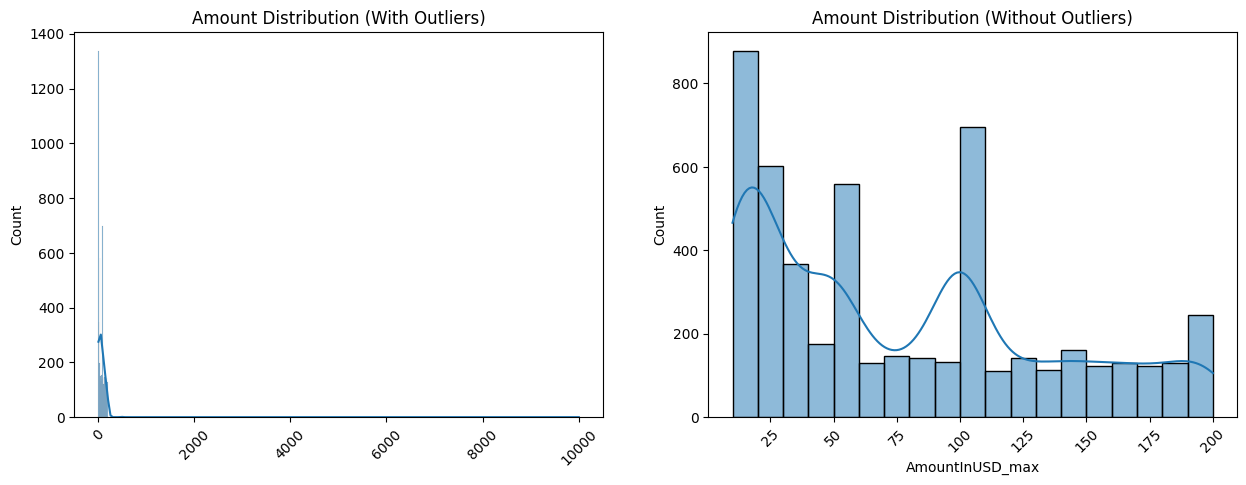

In [51]:
plt.figure(figsize = [15,5])
plt.subplot(1,2,1)
sns.histplot(df_new['AmountInUSD_max'], kde=True)
plt.xticks(rotation = 45)
plt.xlabel(None)
plt.title("Amount Distribution (With Outliers)")

q1 = df_new['AmountInUSD_max'].quantile(0.01)
q3 = df_new['AmountInUSD_max'].quantile(0.99)
df_new2 = df_new[ ( (df_new['AmountInUSD_max'] >= q1) | (df_new['AmountInUSD_max'].isna()) ) & ( (df_new['AmountInUSD_max'] <= q3) | (df_new['AmountInUSD_max'].isna()) ) ]

color = sns.color_palette()[0]
ax = plt.subplot(1,2,2)
sns.histplot(df_new2['AmountInUSD_max'], kde=True, ax =ax)
plt.xticks(rotation = 45)
plt.title("Amount Distribution (Without Outliers)");

In [52]:
df_new.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["AmountInUSD_max"]].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
AmountInUSD_max,5114.0,81.06316,181.018873,10.0,10.0,10.0,10.0,20.0,58.0,131.0,169.7,190.0,200.0,10000.0


In [53]:
df_new2.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["AmountInUSD_max"]].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
AmountInUSD_max,5101.0,76.074691,57.523926,10.0,10.0,10.0,10.0,20.0,58.0,130.0,168.0,189.0,200.0,200.0


### Сравнение метрик тест/контроль (без выбросов)

In [54]:
summary = df_new2.groupby(['tag'],dropna=False).agg({
    'ClientID': ['count'],
    # 'Event_count': ['mean'],
    'charge_flg': ['sum', 'mean'],
    'recurring_flg': ['sum'],
    # 'AmountInUSD_sum': ['sum','mean'],
    # 'AmountInUSD_count': ['sum','mean'],
    'AmountInUSD_max': ['sum','mean']
})
summary.columns = [f'{col[0]}_{col[1]}' for col in summary.columns]
summary.reset_index(inplace=True)
summary.rename(columns={
    'charge_flg_sum': 'donation_count',
    'charge_flg_mean': 'cr',
    'recurring_flg_sum': 'recurring_count',
    'AmountInUSD_max_sum': 'total_amount',
    'AmountInUSD_max_mean': 'avg_amount'
}, inplace=True)
summary['cr'] = summary['cr']*100
summary['rr'] = summary['recurring_count']/summary['donation_count']*100
summary

,tag,ClientID_count,donation_count,cr,recurring_count,total_amount,avg_amount,rr
0,control,21146,2453,11.600303,104,196049.0,79.922136,4.239706
1,test,21102,2648,12.548574,71,192008.0,72.510574,2.681269


### Регулярные платежи

Необходимо учесть, что рекуррентные платежи в совокупности принесут нам больше. Можем предположить, что минимум X месяцев мы будем получать эти платежи. Для более точной оценки нужно проанализировать исторические данные, заложить дисконтирование и прочие разные эффекты.

Фактически, в этом анализе можем обратить внимание, что эффект сонаправленный, т.е. в тестовой группе совокупный объем донатов меньше, чем в контрольной. Таким образом, для текущего анализа нет практической пользы корректировать рекуррентные платежи.

In [55]:
summary = df_new[df_new['recurring_flg']==1].groupby(['tag'],dropna=False).agg({
    'ClientID': ['count'],
    # 'Event_count': ['mean'],
    'charge_flg': ['sum', 'mean'],
    'recurring_flg': ['sum'],
    # 'AmountInUSD_sum': ['sum','mean'],
    # 'AmountInUSD_count': ['sum','mean'],
    'AmountInUSD_max': ['sum','mean']
})
summary.columns = [f'{col[0]}_{col[1]}' for col in summary.columns]
summary.reset_index(inplace=True)
summary.rename(columns={
    'charge_flg_sum': 'donation_count',
    'charge_flg_mean': 'cr',
    'recurring_flg_sum': 'recurring_count',
    'AmountInUSD_max_sum': 'total_amount',
    'AmountInUSD_max_mean': 'avg_amount'
}, inplace=True)
summary['cr'] = summary['cr']*100
summary['rr'] = summary['recurring_count']/summary['donation_count']*100
summary

,tag,ClientID_count,donation_count,cr,recurring_count,total_amount,avg_amount,rr
0,control,104,104,100.0,104,3961.0,38.086538,100.0
1,test,71,71,100.0,71,3932.0,55.380282,100.0


In [56]:
summary_group = df_new[(df_new['charge_flg']==1) & (df_new['recurring_flg']==1)].groupby(['tag','AmountInUSD_max_category']).agg({
    'AmountInUSD_max': ['sum']
})
summary_group.columns = [f'{col[0]}_{col[1]}' for col in summary_group.columns]
summary_group.reset_index(inplace=True)
summary_group

fig = px.bar(summary_group, x="AmountInUSD_max_category", y="AmountInUSD_max_sum", color="tag", barmode="group",
             title="recurring amount by test group and price category")

fig.show()

# Гипотезы и статистический анализ

Сравнение метрик в контрольной и тестовой группе показало, что конверсия увеличилась, но при этом уменьшился размер среднего пожертвования. На самом деле, предполагаю, что для компании интереснее получить больше денег. Поэтому проведем анализ теста по совокупной сумме донатов.

### Гипотеза 1
**Сумма пожертвований в тестовой группе изменится.**

Используем bootstrap для оценки доверительных интервалов и проверку гипотезы.

In [67]:
# Aggregate total donation amount by group
total_donations = df_new2.groupby('tag')['AmountInUSD_sum'].sum().reset_index()
print(total_donations)

# Define bootstrap function
def bootstrap(data, n_bootstrap=1000):
    means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        means.append(np.sum(sample))
    return means

# Perform bootstrap for both groups
control_data = df_new2[df_new2['tag'] == 'control']['AmountInUSD_sum'].values
test_data = df_new2[df_new2['tag'] == 'test']['AmountInUSD_sum'].values

control_bootstrap = bootstrap(control_data)
test_bootstrap = bootstrap(test_data)

# Calculate 95% confidence intervals
control_ci = np.percentile(control_bootstrap, [2.5, 97.5])
test_ci = np.percentile(test_bootstrap, [2.5, 97.5])

print(f"Control group 95% CI: {control_ci}")
print(f"Test group 95% CI: {test_ci}")


       tag  AmountInUSD_sum
0  control         199023.0
1     test         194663.0
Control group 95% CI: [189859.875 208542.1  ]
Test group 95% CI: [185378.125 204076.4  ]


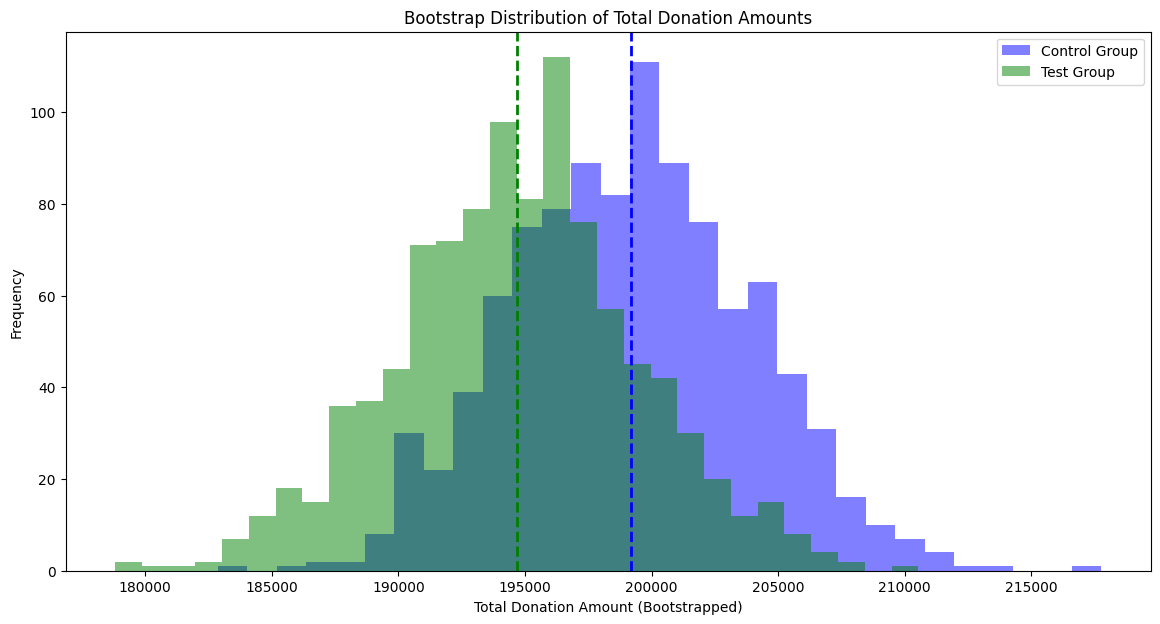

In [59]:
# Visualize the distributions
plt.figure(figsize=(14, 7))
plt.hist(control_bootstrap, bins=30, alpha=0.5, label='Control Group', color='blue')
plt.hist(test_bootstrap, bins=30, alpha=0.5, label='Test Group', color='green')
plt.axvline(np.mean(control_bootstrap), color='blue', linestyle='dashed', linewidth=2)
plt.axvline(np.mean(test_bootstrap), color='green', linestyle='dashed', linewidth=2)
plt.xlabel('Total Donation Amount (Bootstrapped)')
plt.ylabel('Frequency')
plt.title('Bootstrap Distribution of Total Donation Amounts')
plt.legend()
plt.show()


### Вывод 1
Так как доверительные интервалы пересекаются, изменение, вероятно, не является статистически значимым.

### Гипотеза 2

Далее, посмотрим отдельно метрику среднее пожертвование.
Гипотеза:

**Среднее пожертвование изменится**.

Используем t-тест. ЦПТ позволяет нам использовать t-тест для сравнения средних значений даже если исходные данные не распределены нормально, при условии, что выборки достаточно большие

In [64]:
charges = df_new2[df_new2['charge_flg'] == 1]

# Calculate average donation amount by group
average_donations = charges.groupby('tag')['AmountInUSD_sum'].mean().reset_index()
print(average_donations)

# Check the sizes of the groups
control_data = charges[charges['tag'] == 'control']['AmountInUSD_sum'].values
test_data = charges[charges['tag'] == 'test']['AmountInUSD_sum'].values

print(f"Размер выборки контрольной группы: {len(control_data)}")
print(f"Размер выборки тестовой группы: {len(test_data)}")

# Perform t-test
t_stat, p_value = ttest_ind(control_data, test_data)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("Различия в средних значениях статистически значимы.")
else:
    print("Различия в средних значениях не являются статистически значимыми.")


       tag  AmountInUSD_sum
0  control        81.134529
1     test        73.513218
Размер выборки контрольной группы: 2453
Размер выборки тестовой группы: 2648
T-statistic: 4.686440835656681, P-value: 2.8523294078168958e-06
Различия в средних значениях статистически значимы.


Control group mean: 81.13452914798206, 95% CI: [78.84748440528458, 83.42157389067955]
Test group mean: 73.5132175226586, 95% CI: [71.29449967398973, 75.73193537132748]
T-statistic: 4.686440835656681, P-value: 2.8523294078168958e-06
Minimal Detectable Effect (MDE): 4.55469166510459


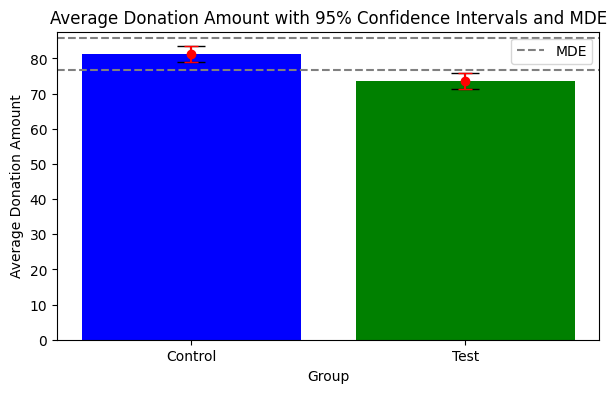

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, norm

charges = df_new2[df_new2['charge_flg'] == 1]

# Check the sizes of the groups
control_data = charges[charges['tag'] == 'control']['AmountInUSD_sum'].values
test_data = charges[charges['tag'] == 'test']['AmountInUSD_sum'].values

# Calculate means
mean_control = np.mean(control_data)
mean_test = np.mean(test_data)

# Calculate standard errors
se_control = np.std(control_data, ddof=1) / np.sqrt(len(control_data))
se_test = np.std(test_data, ddof=1) / np.sqrt(len(test_data))

# Calculate confidence intervals
alpha = 0.05
z_score = norm.ppf(1 - alpha / 2)
ci_control = [mean_control - z_score * se_control, mean_control + z_score * se_control]
ci_test = [mean_test - z_score * se_test, mean_test + z_score * se_test]

# Perform t-test
t_stat, p_value = ttest_ind(control_data, test_data)

# Calculate MDE
power = 0.8  # Typically desired power
beta = 1 - power
z_beta = norm.ppf(power)
pooled_se = np.sqrt(se_control**2 + se_test**2)
mde = (z_score + z_beta) * pooled_se

print(f"Control group mean: {mean_control}, 95% CI: {ci_control}")
print(f"Test group mean: {mean_test}, 95% CI: {ci_test}")
print(f"T-statistic: {t_stat}, P-value: {p_value}")
print(f"Minimal Detectable Effect (MDE): {mde}")

# Plot means with confidence intervals and MDE
plt.figure(figsize=(7, 4))
groups = ['Control', 'Test']
means = [mean_control, mean_test]
ci_lower = [ci_control[0], ci_test[0]]
ci_upper = [ci_control[1], ci_test[1]]

plt.bar(groups, means, yerr=[mean_control - ci_control[0], mean_test - ci_test[0]], capsize=10, color=['blue', 'green'])
plt.errorbar(groups, means, yerr=[mean_control - ci_control[0], mean_test - ci_test[0]], fmt='o', color='red', capsize=5)

plt.axhline(y=mean_control + mde, color='gray', linestyle='--', label='MDE')
plt.axhline(y=mean_control - mde, color='gray', linestyle='--')

plt.xlabel('Group')
plt.ylabel('Average Donation Amount')
plt.title('Average Donation Amount with 95% Confidence Intervals and MDE')
plt.legend()
plt.show()


### Вывод 2
Тут мы с уверенностью можем заявить, что изменения статистически значимые.

# Результаты и рекомендации

### Результаты:

📍 Конверсия значимо выросла (проверил критерием хи-квадрат) с 11.6% до 12.6%, т.е. некоторых пользователей отпугивала предзаполненная сумма.

📍 Размер среднего пожертвования сократился значимо, если убрать экстремально большие донаты. Их стоит рассмотреть отдельно на исторических данных, в данном анализе они удалены

📍 Рекуррентные платежи. По скольку таких платежей немного (около 2-4% от всех) и тест повлиял на эту группу сонаправлено общему эффекту, в этом анализе эта метрика игнорируется. Но точно имеет смысл проанализировать эту группу с учетом исторических данных

📍 Главная метрика - сумма всех пожертвований. Доверительные интервалы пересекаются, поэтому мы не можем отвергнуть нулевую гипотезу. Следовательно не можем сказать о росте или падении.


### Рекомендации:

- Изучить выбросы в исторической перспективе. Идея в том, что предзаполненная сумма снижает размер крупного доната на несколько порядков.
- Имеет смысл **протестировать другие предзаполненные суммы, другие значения подсказок или другой тип платежа по умолчанию (регулярный, разовый)**.
Например, посмотреть другие суммы в диапазоне 75-100, что, вероятно, увеличит конверсию, не уронив средний донат.
Также, исследовать другие комбинации, в том числе бОльшие предзаполненные суммы. Гипотеза: конверсия снизится, но совокупное пожертвование увеличится.